In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import arviz as az

In [3]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
from agnfinder.tf_sampling.api import SamplingProblem
from agnfinder.tf_sampling.hmc import SamplerHMC
from agnfinder import simulation_utils, simulation_samples
from agnfinder.prospector import visualise, main, cpz_builders

Using TensorFlow backend.


In [4]:
tf.enable_eager_execution()

In [5]:
os.chdir('/home/mike/repos/agnfinder')

In [6]:
_, _, x_test, y_test = deep_emulator.data()
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [7]:
galaxy_n = 5
true_params = x_test[galaxy_n]
true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [8]:
galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)

In [9]:
samples, _, _ = run_sampler.read_h5(galaxy_loc)

In [10]:
samples_by_chain = [samples[:, n, :] for n in range(samples.shape[1])]

In [11]:
param_names = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']

In [12]:
data = []
for chain_n, chain in enumerate(samples_by_chain):
    for sample_n, sample in enumerate(chain):
        series = dict(zip(param_names, sample))
        series['chain'] = chain_n
        series['sample'] = sample_n
        data.append(series)

In [13]:
df = pd.DataFrame(data)

In [14]:
df.head()

,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,chain,sample
0,0.554882,0.338813,0.636792,0.674759,0.129612,0.347483,0.060443,0,0
1,0.554882,0.338813,0.636792,0.674759,0.129612,0.347483,0.060443,0,1
2,0.547309,0.338991,0.639822,0.671037,0.130811,0.344034,0.056171,0,2
3,0.560273,0.349675,0.651050,0.660730,0.122801,0.339498,0.053095,0,3
4,0.558730,0.347687,0.641400,0.663725,0.124826,0.340779,0.054851,0,4


In [15]:
len(df)

576000

In [16]:
df_to_plot = df[param_names + ['chain']].query('chain < 5').sample(1000)

In [17]:
len(df_to_plot)

1000

 /media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:invalid value encountered in true_divide
 /media/mike/Windows/linux_cache/miniconda37/envs/agnfinder/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:invalid value encountered in double_scalars


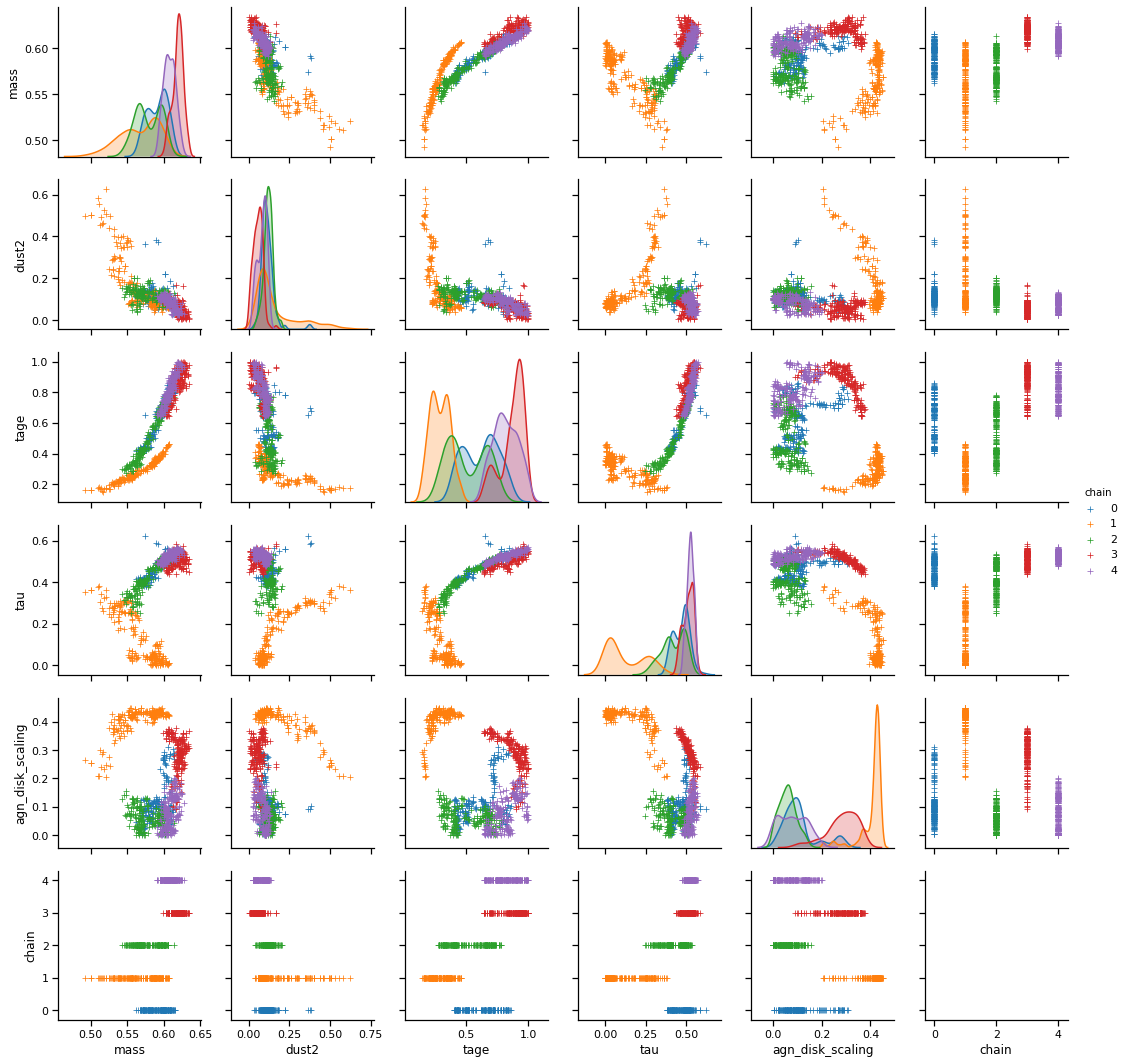

In [18]:
sns.pairplot(df_to_plot[['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'chain']], hue='chain', markers="+")

In [19]:
ds = az.convert_to_dataset(np.swapaxes(samples, 0, 1)[:5], coords=dict(zip(param_names, range(len(param_names)))))  # first 5 chains, for clarity

In [20]:
ds

<xarray.Dataset>
Dimensions:  (chain: 5, draw: 6000, x_dim_0: 7)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 5993 5994 5995 5996 5997 5998 5999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6
Data variables:
    x        (chain, draw, x_dim_0) float32 0.554882 0.3388134 ... 0.13197827
Attributes:
    created_at:  2020-01-08T12:01:59.264159

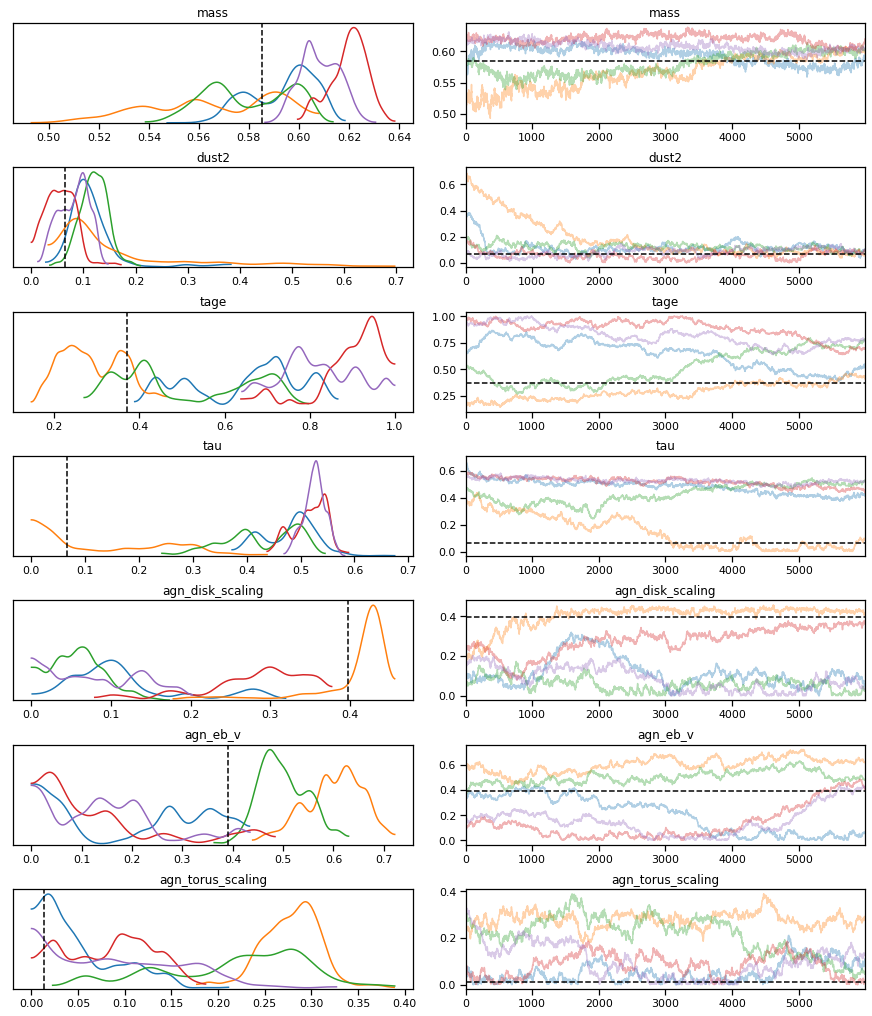

In [21]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(param_names[param_n])
    axes[param_n][1].set_title(param_names[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')